In [ ]:
  b from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#mention dataset for BERT Model-1
dataset_path='/content/gdrive/MyDrive/MANTHAN/toxicity_dataset.csv'

#mention path of BERT Model-1-b(bert-1 refers to the model for hate content classification and d is the model which was obtained by training the c version)
model_path='/content/gdrive/MyDrive/MANTHAN/bert-2-model-1'

In [ ]:
import pandas as pd

df=pd.read_csv(dataset_path)
df

,Unnamed: 0,clean_text,label
0,0,explan edit made under usernam hardcor metalli...,0
1,1,match thi background colour seemingli stuck wi...,0
2,2,realli tri edit just that thi constantli remov...,0
3,3,more make real suggest improv wonder section s...,0
4,4,hero chanc rememb what page that,0
...,...,...,...
21343,21343,faggot faggot faggot faggot,5
21344,21344,angri fuck bitch,5
21345,21345,angri fuck bitch,5
21346,21346,fuck block faggot pussi,5


In [ ]:
df.shape

(21348, 3)

In [ ]:
df['label'].value_counts()

5    3558
4    3558
3    3558
2    3558
1    3558
0    3558
Name: label, dtype: int64

In [ ]:
X=list(df['clean_text'])

In [ ]:
y=list(df['label'])

In [ ]:
#there are 6 categories:
# -toxic-0
# -severe_toxic-1
# -obscene-2
# -threat-3
# -insult-4
# -identity_hate-5

set(y)

{0, 1, 2, 3, 4, 5}

In [ ]:
from sklearn.model_selection import train_test_split

#20% for testing and 80% for training-the ideal train-test split
X_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [ ]:
len(X_train),len(y_train)

(17078, 17078)

In [ ]:
len(x_test),len(y_test)

(4270, 4270)

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 61 kB 486 kB/s 
     |████████████████████████████████| 3.3 MB 34.9 MB/s 
     |████████████████████████████████| 596 kB 45.5 MB/s 
     |████████████████████████████████| 895 kB 21.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#Import the pre-trained BERT model:DistilBERT and the necessaary tokenizer to perform text pre-processing

from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
#BERT takes word embeddings as input.So,generate them for all the samples in the train and test datasets using the BERT tokenizer itself

train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(x_test, truncation=True, padding=True)

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))


In [ ]:
#TFDistilBertForSequenceClassification is the category of the pre-trained DistilBert model which we are using

from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments



In [ ]:
#train bert model on GPU

loaded_model = TFDistilBertForSequenceClassification.from_pretrained(model_path)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)


loaded_model.compile(optimizer=optimizer, loss=loaded_model.compute_loss, metrics=['accuracy'])

history=loaded_model.fit(train_dataset.shuffle(100).batch(16),
          epochs=3,
          batch_size=32)

#here,load the saved model i.e., the previous version bert-1-model-1-d and train this for 5 more epochs
#this is done due to the RAM considerations of Google Colab and keeping the GPU usage in mind


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/gdrive/MyDrive/MANTHAN/bert-2-model-1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Epoch 1/3
1068/1068 [==============================] - 1881s 2s/step - loss: 0.1290 - accuracy: 0.9538
Epoch 2/3
1068/1068 [==============================] - 1863s 2s/step - loss: 0.0601 - accuracy: 0.9815
Epoch 3/3
1068/1068 [==============================] - 1870s 2s/step - loss: 0.0498 - accuracy: 0.9850


In [ ]:
model_save_path="/content/gdrive/MyDrive/MANTHAN/bert-2-model-2"
loaded_model.save_pretrained(model_save_path)
#save the current model as 2

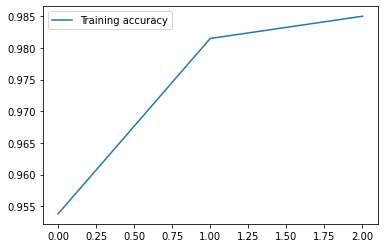

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label="Training accuracy")
plt.legend()

plt.savefig('bert2-acc.png')
plt.show()

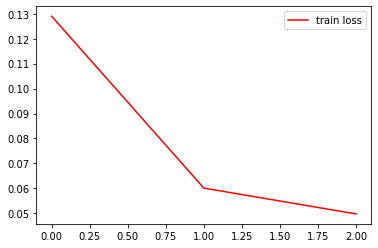

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss',color='red')

plt.legend()

plt.savefig('bert2-acc.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np

#predict using the loaded model
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(model_save_path)
y_pred=[]

for test_sentence in x_test:
  predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

  tf_output = loaded_model.predict(predict_input)[0]
  tf_prediction = tf.nn.softmax(tf_output, axis=1).numpy()
  ans=np.argmax(tf_prediction,axis=1)
  y_pred.append(ans)


Some layers from the model checkpoint at /content/gdrive/MyDrive/MANTHAN/bert-2-model-2 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/gdrive/MyDrive/MANTHAN/bert-2-model-2 and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
categories=["toxic","severe-toxic","obscene","threat","insult","identity-hate"]
print(classification_report(y_pred,y_test,target_names=categories))

               precision    recall  f1-score   support

        toxic       0.88      1.00      0.93       619
 severe-toxic       0.99      0.90      0.94       835
      obscene       1.00      0.99      0.99       698
       threat       1.00      0.99      1.00       699
       insult       1.00      1.00      1.00       704
identity-hate       1.00      1.00      1.00       715

     accuracy                           0.98      4270
    macro avg       0.98      0.98      0.98      4270
 weighted avg       0.98      0.98      0.98      4270



In [ ]:
confusion_matrix(y_pred,y_test)

array([[617,   2,   0,   0,   0,   0],
       [ 80, 752,   3,   0,   0,   0],
       [  2,   7, 689,   0,   0,   0],
       [  5,   1,   0, 693,   0,   0],
       [  0,   0,   0,   0, 704,   0],
       [  0,   0,   0,   0,   0, 715]])